Let's check that our dataset is appropriate for the distilbert tokenizer. Are our examples mostly less than 512 tokens?

<a href="https://colab.research.google.com/github/jkchandalia/nlp/blob/main/Poetry_w_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
# %%capture
# !pip install transformers
# !pip install datasets
# !pip install evaluate
# !pip install torch
# !pip install matplotlib

In [78]:
from datasets import load_dataset
from transformers import AutoTokenizer
import pandas as pd

# Step 1: Load, inspect and down-sample our dataset

In [79]:
dataset = load_dataset("yelp_review_full")
dataset_small = dataset["train"].train_test_split(train_size=100, test_size=100, seed=42, stratify_by_column="label")

Found cached dataset yelp_review_full (/Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)
100%|██████████| 2/2 [00:00<00:00, 185.58it/s]
Loading cached split indices for dataset at /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-fad11cb6e689c3c5.arrow and /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-8d5301c1f758ac0d.arrow


# Step 2: Tokenize our training and test datasets

In [80]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") # uncased means lowercase

def tokenize_function(examples):
    """this time we won't truncate the examples so that we can evaluate the distribution of the number of tokens for our reviews
    """
    # prior implementation we used for training: return tokenizer(examples["text"], padding="max_length", truncation=True)
    return tokenizer(examples["text"])

tokenized_datasets = dataset_small.map(tokenize_function, batched=True)

Loading cached processed dataset at /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-3cb31ec9adba75d6.arrow
Loading cached processed dataset at /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-b4f946d8ec082f69.arrow


Discussion Question: given the description of the tokenize_function() above, before we proceed, can you think of any potential problems with this approach? How would you go about evaluating if this approach is appropriate for our use-case? (side exercise: ex2_inspect_dataset.ipynb)

In [81]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 100
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 100
    })
})

In [82]:
# tokenized_datasets["train"][0]

In [83]:
train_df = pd.DataFrame(tokenized_datasets["train"])

In [84]:
train_df["input_ids"].apply(len).describe()

count     100.000000
mean      165.750000
std       148.020158
min        12.000000
25%        73.250000
50%       120.500000
75%       228.750000
max      1043.000000
Name: input_ids, dtype: float64

<Axes: >

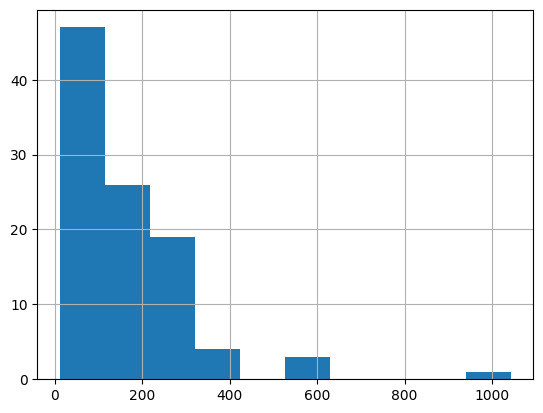

In [85]:
train_df["input_ids"].apply(len).hist()

In [86]:
train_df["input_ids_token_length"] = train_df["input_ids"].apply(len)

In [87]:
train_df[train_df["input_ids_token_length"] > 512]

,label,text,input_ids,attention_mask,input_ids_token_length
32,1,"We came on a Friday night for dinner, and book...","[101, 2057, 2234, 2006, 1037, 5958, 2305, 2005...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1043
76,0,This was the first time my husband and I have ...,"[101, 2023, 2001, 1996, 2034, 2051, 2026, 3129...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",611
77,4,Its a typical Saturday morning. \nYou're hungo...,"[101, 2049, 1037, 5171, 5095, 2851, 1012, 1032...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",611
92,3,Icehouse is a controversially good place. I've...,"[101, 3256, 4580, 2003, 1037, 6801, 2135, 2204...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",544


In [88]:
longest_review = train_df[train_df["input_ids_token_length"] > 512]["text"].values[0]

In [89]:
longest_review.replace(". ", "\\n\\").split("\\n\\")

['We came on a Friday night for dinner, and booked a table through Open Table',
 'And we are also Landry Club member',
 'So we would think that it would be a nice dinner',
 'It turned out that the dinner was an upsetting experience because of a very bad server.',
 'nWe ordered a Capricciosa Pizza and ONE caesar salad',
 'When the salad came, we were given 2 half salads',
 'I was already feeling weird about it',
 'When we ordered, we did say A caesar salad',
 'We didn\'t say \\"two half caesar salads\\"',
 "And we weren't asked if we would like to split it too",
 'But it came out split',
 "So I wasn't sure what was going on",
 "I didn't even know that we would be charged more for comsuming the 2 half salads",
 'We just thought that maybe they were nice enough to split it into 2 portions',
 "We weren't asked at all so and the menu didn't even state any option of half salad of splitting salad",
 "So we didn't have any clue that we should have asked about it before putting the salad into o

# Run analysis on the entire dataset
You might not want to execute these cells as it may take awhile

In [90]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_df = pd.DataFrame(tokenized_datasets["train"])
train_df["input_ids"].apply(len).describe()

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1019 > 512). Running this sequence through the model will result in indexing errors
Loading cached processed dataset at /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-46cd1329140d1549.arrow


count    650000.000000
mean        180.696091
std         163.847267
min           3.000000
25%          71.000000
50%         132.000000
75%         236.000000
max        2344.000000
Name: input_ids, dtype: float64

<Axes: >

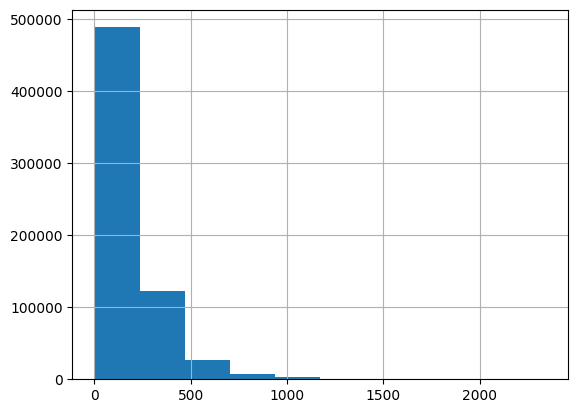

In [91]:
train_df["input_ids"].apply(len).hist()

In [92]:
train_df["input_ids_token_length"] = train_df["input_ids"].apply(len)

In [93]:
train_df[train_df["input_ids_token_length"] > 512].sort_values(by="input_ids_token_length", ascending=False).head()

,label,text,input_ids,attention_mask,input_ids_token_length
614419,3,"Pour le jour de l'an 2010, nous \u00e9tions a ...","[101, 10364, 3393, 8183, 3126, 2139, 1048, 100...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2344
546323,4,**Summary**\n - Best - I have to start b...,"[101, 1008, 1008, 12654, 1008, 1008, 1032, 105...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2045
466919,2,"Torii @ Lavel, Quecec, Canada, \u30ab\u30ca\u3...","[101, 23413, 2072, 1030, 2474, 15985, 1010, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1966
570102,4,"WED, MARCH 27, 2013 // 12:00PM-2:00PM \n ...","[101, 21981, 1010, 2233, 2676, 1010, 2286, 101...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1903
603624,1,"Was hier rumsitzt kennt das Angebot, diese bun...","[101, 2001, 7632, 2121, 19379, 28032, 2480, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1896


In [94]:

train_df[train_df["input_ids_token_length"] > 512].shape[0] / train_df.shape[0]

0.04655846153846154

#### Observation:  
 
 Less than 5% of the reviews are longer than 512 tokens (which is the maximum length of the input for the DistilBERT model) meaning they will be truncated and we will lose information. This isn't ideal because we want to be able to classify the sentiment of the entire review, not just the first 512 tokens. 

For our use case, it seems reasonable (intuitively) that our model can assess the sentiment of a review based on the first 512 tokens. This analysis is still useful as it gives us a quantitative measure of our information loss by using Distilbert.

##### Alternative approaches for a use-case where the entire text is important:
    - We could try to split the reviews into multiple segments and then use the model to classify each segment and then aggregate the results to get a final sentiment score.  
    - We could try to use a model that doesn't have a maximum length, such as XLNet. This would allow us to classify the sentiment of the entire review, but it would also mean that we would need to pad the input to the maximum length of the dataset, which would be wasteful for the majority of reviews that are shorter than the maximum length. That will come at the cost of increased model size and training time.

In [95]:
longest_review = train_df[train_df["input_ids_token_length"] > 512]["text"].values[0]

# Run the tokenizer on individual examples

In [96]:

tokenized_example_not_truncated = tokenizer(longest_review, return_tensors="pt") # return_tensors="pt" means return pytorch tensors


In [97]:
tokenized_example_not_truncated.data

{'input_ids': tensor([[  101,  2044,  1037,  ..., 27172,  1012,   102]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}

In [98]:
tokenized_example_not_truncated["input_ids"][0].shape

torch.Size([1019])

In [99]:
tokenized_example_truncated = tokenizer("longest_review", padding="max_length", truncation=True, return_tensors="pt")
tokenized_example_truncated["input_ids"][0].shape

torch.Size([512])

In [100]:
tokenized_example_padded = tokenizer("Solid haircut", padding="max_length", truncation=True, return_tensors="pt")
tokenized_example_padded["input_ids"][0].shape

torch.Size([512])

In [101]:
tokenized_example_padded = tokenizer("Solid haircut", padding="max_length", truncation=True, return_tensors="pt")
tokenized_example_padded["input_ids"][0].shape

torch.Size([512])

## Inspect the string representations of the tokens

In [102]:
# decode the tokenized example
tokenized_example = tokenizer("Solid haircut", padding="max_length", truncation=True, return_tensors="pt")
tokenizer.decode(tokenized_example["input_ids"][0])

'[CLS] solid haircut [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [103]:
# try your name
tokenized_example = tokenizer("Dana Engebretson embedding", padding="max_length", truncation=True, return_tensors="pt")
tokenizer.decode(tokenized_example["input_ids"][0]) # why is this not breaking engebretson into separate tokens like below with tokenizer.tokenize?

'[CLS] dana engebretson embedding [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [104]:
tokenizer.tokenize("Dana Engebretson")

['dana', 'eng', '##eb', '##ret', '##son']